In [1]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import KFold, cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [3]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [4]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2

1. run the estimation of comb of all
2. store the prediction and label 
3. read them and calculate mean 
4. for every subject calculate spearman's rho with UPDRS and 
    1. prediction amplitude 
    2. delta label and prediction 


In [5]:
os.listdir(PATH_)

['sub_000_sess_right_run_0.p',
 'sub_000_sess_right_run_1.p',
 'sub_000_sess_right_run_2.p',
 'sub_000_sess_right_run_3.p',
 'sub_001_sess_left_run_0.p',
 'sub_001_sess_left_run_1.p',
 'sub_001_sess_left_run_3.p',
 'sub_001_sess_left_run_6.p',
 'sub_001_sess_left_run_7.p',
 'sub_001_sess_right_run_2.p',
 'sub_001_sess_right_run_4.p',
 'sub_001_sess_right_run_5.p',
 'sub_002_sess_right_run_0.p',
 'sub_002_sess_right_run_1.p',
 'sub_003_sess_left_run_1.p',
 'sub_003_sess_left_run_3.p',
 'sub_003_sess_right_run_0.p',
 'sub_003_sess_right_run_2.p',
 'sub_003_sess_right_run_4.p',
 'sub_003_sess_right_run_5.p',
 'sub_004_sess_left_run_0.p',
 'sub_004_sess_right_run_1.p',
 'sub_004_sess_right_run_2.p',
 'sub_005_sess_left_run_0.p',
 'sub_005_sess_left_run_1.p',
 'sub_005_sess_left_run_3.p',
 'sub_005_sess_left_run_4.p',
 'sub_005_sess_right_run_2.p',
 'sub_006_sess_left_run_0.p',
 'sub_006_sess_left_run_3.p',
 'sub_006_sess_left_run_5.p',
 'sub_006_sess_right_run_1.p',
 'sub_006_sess_right_ru

In [397]:
# COMBINATION ECOG, STN and both
df = pd.DataFrame()
time_stamps = 5

for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        X_ = []
        start = True
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            #ECOG_STN combines all 
            X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], \
                                   run_["label_baseline_corrected"][0,:], \
                                   time_stamps=time_stamps)
            if start == True:
                X_ = X
                start = False
            else:
                X_ = np.concatenate((X_, X), axis=1)

        for label_idx, label in enumerate(run_["label_baseline_corrected"]):
            pred_ = []
            label_ = []
            r2_ = []
            cv = KFold(n_splits=5, shuffle=False)
            for train_index, test_index in cv.split(X):
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=label[time_stamps:]), 
                #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                Xtr, Xte=X_[train_index,:], X_[test_index,:]
                ytr, yte=label[time_stamps:][train_index], label[time_stamps:][test_index]
                model = xgb.XGBRegressor()
                model.fit(Xtr, ytr)
                pred_.append(model.predict(Xte))
                label_.append(yte)
                r2_score = metrics.r2_score(yte, model.predict(Xte))
                if r2_score < 0:
                    r2_.append(0)
                else:
                    r2_.append(r2_score)
            if run_["label_con_true"][label_idx] is True:
                lat = "CON"
            else:
                lat = "IPS"
            if "LEFT" in ch_:
                hem = "LEFT"
            else:
                hem = "RIGHT"
            df = df.append({
                "sub": sub_,
                "lat": lat, 
                "hem": hem, 
                "pred" : np.concatenate(pred_), 
                "label" : np.concatenate(label_), 
                "r2" : np.mean(r2_)
            }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', '

In [398]:
def get_epochs(y_test, y_pred, epoch_lim=20, threshold=0.5):
    ind_mov = np.where(np.diff(np.array(y_test>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_test.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    y_pred_epoch = np.zeros([ind_mov.shape[0], epoch_lim*2])
    y_true_arr = np.zeros([ind_mov.shape[0], epoch_lim*2])

    for idx, i in enumerate(ind_mov):
        y_pred_epoch[idx,:] = y_pred[i-epoch_lim:i+epoch_lim]
        y_true_arr[idx,:] = y_test[i-epoch_lim:i+epoch_lim]

    return y_true_arr, y_pred_epoch

### concatenate every session and con and ips

In [399]:
dict_ = {}
for sub in df["sub"].unique():
    start = True
    r2_ = []
    for hem in ["RIGHT", "LEFT"]:
        for lat in ["CON", "IPS"]:
            df_extract = df[(df["sub"] == sub) &(df["lat"] == lat) & (df["hem"] == hem)]
            if df_extract.shape[0] == 0:
                continue
            if start == True:
                start = False
                y_pr = df_extract["pred"].iloc[0]
                y_true = df_extract["label"].iloc[0]
                r2_.append(df_extract["r2"].iloc[0])
            else:
                y_pr = np.concatenate((y_pr, df_extract["pred"].iloc[0]), axis=0)
                y_true = np.concatenate((y_true, df_extract["label"].iloc[0]), axis=0)
                r2_.append(df_extract["r2"].iloc[0])

    dict_[sub] = {
        "pred" : y_pr,
        "true" : y_true, 
        "r2" : np.mean(r2_)
    }

### read UPDRS scores and calculate epochs

In [107]:
df_UPDRS = pd.read_csv("..\\df_all.csv", index_col=0)

In [322]:
df_comp = pd.DataFrame()
epoch_lim = 30
mean_arr_delta = np.zeros([epoch_lim*2, 11])
mean_arr_pred = np.zeros([epoch_lim*2, 11])
updrs = []
start = True

for sub_idx, sub in enumerate(['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']):
    updrs.append(list(df_UPDRS[(df_UPDRS["sub"] == int(sub))]["UPDRS_total"])[0])
    y_epoch_true, y_epoch_pr = get_epochs(dict_[sub]["true"], dict_[sub]["pred"], \
                                          threshold=0.5, epoch_lim=epoch_lim)
    if start is True:
        y_TRUE = y_epoch_true; y_PRED = y_epoch_pr
        start = False
    else: 
        y_TRUE = np.concatenate((y_TRUE, y_epoch_true), axis=0)
        y_PRED = np.concatenate((y_PRED, y_epoch_pr), axis=0)
    if sub == "000":
        y_TRUE_000 = y_TRUE
        y_PRED_000 = y_PRED
    if sub == "010":
        y_TRUE_010 = y_TRUE
        y_PRED_010 = y_PRED
    mean_arr_pred[:, sub_idx] = np.mean(y_epoch_pr, axis=0)
    mean_arr_delta[:, sub_idx] = np.mean(y_epoch_true, axis=0) - np.mean(y_epoch_pr, axis=0)

### calculate spearman's rho for every 10Hz iteration 

In [40]:
mean_arr_delta.shape

(60, 11)

In [41]:
sprho_arr_delta = np.zeros([epoch_lim*2])
sprho_arr_pred = np.zeros([epoch_lim*2])
for i in range(epoch_lim*2):
    sprho_arr_delta[i] = stats.spearmanr(mean_arr_delta[i,:], updrs)[0]
    sprho_arr_pred[i] = stats.spearmanr(mean_arr_pred[i,:], updrs)[0]

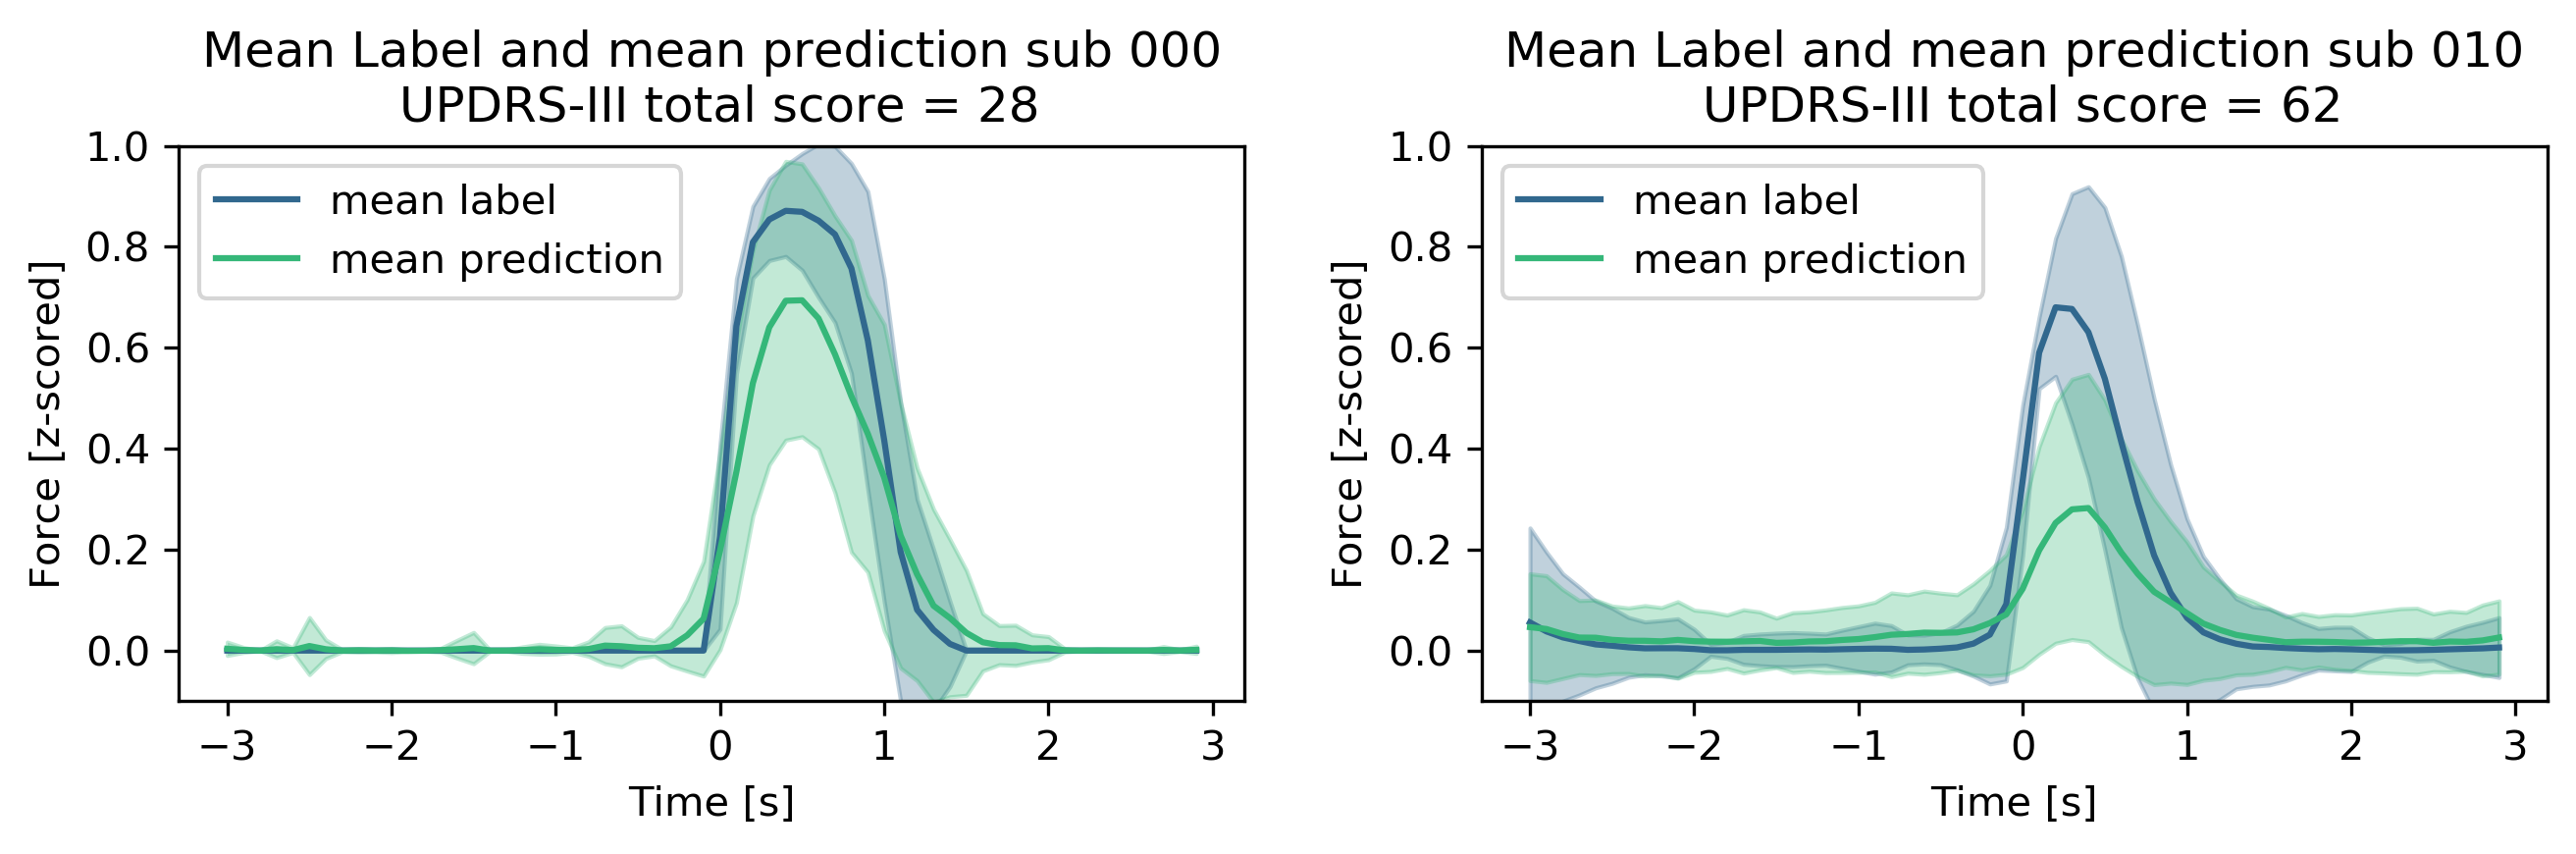

In [95]:
plt.figure(figsize=(9,3), dpi=300)
plt.subplot(121)
plt.xlabel("Time [s]")
plt.ylabel("Force [z-scored]")
plt.plot(x_, y_TRUE_000.mean(axis=0), label="mean label", color=(49/255,104/255,142/255))
plt.plot(x_, y_PRED_000.mean(axis=0), label="mean prediction", color=(53/255,183/255,121/255))
plt.fill_between(x_,y_TRUE_000.mean(axis=0)-y_TRUE_000.std(axis=0), y_TRUE_000.mean(axis=0)+y_TRUE_000.std(axis=0), 
                alpha=0.3, color=(49/255,104/255,142/255))
plt.fill_between(x_,y_PRED_000.mean(axis=0)-y_PRED_000.std(axis=0), y_PRED_000.mean(axis=0)+y_PRED_000.std(axis=0), 
                alpha=0.3, color=(53/255,183/255,121/255))
plt.title("Mean Label and mean prediction sub 000\n UPDRS-III total score = 28")
plt.legend(loc="upper left")
plt.ylim(-0.1, 1)

plt.subplot(122)
plt.xlabel("Time [s]")
plt.ylabel("Force [z-scored]")
plt.plot(x_, y_TRUE_010.mean(axis=0), label="mean label", color=(49/255,104/255,142/255))
plt.plot(x_, y_PRED_010.mean(axis=0), label="mean prediction", color=(53/255,183/255,121/255))
plt.fill_between(x_,y_TRUE_010.mean(axis=0)-y_TRUE_010.std(axis=0), y_TRUE_010.mean(axis=0)+y_TRUE_010.std(axis=0), 
                alpha=0.3, color=(49/255,104/255,142/255))
plt.fill_between(x_,y_PRED_010.mean(axis=0)-y_PRED_010.std(axis=0), y_PRED_010.mean(axis=0)+y_PRED_010.std(axis=0), 
                alpha=0.3, color=(53/255,183/255,121/255))
plt.title("Mean Label and mean prediction sub 010\n UPDRS-III total score = 62")
plt.legend(loc="upper left")
plt.ylim(-0.1, 1)
plt.tight_layout()

Text(0, 0.5, 'Force [z-scored]')

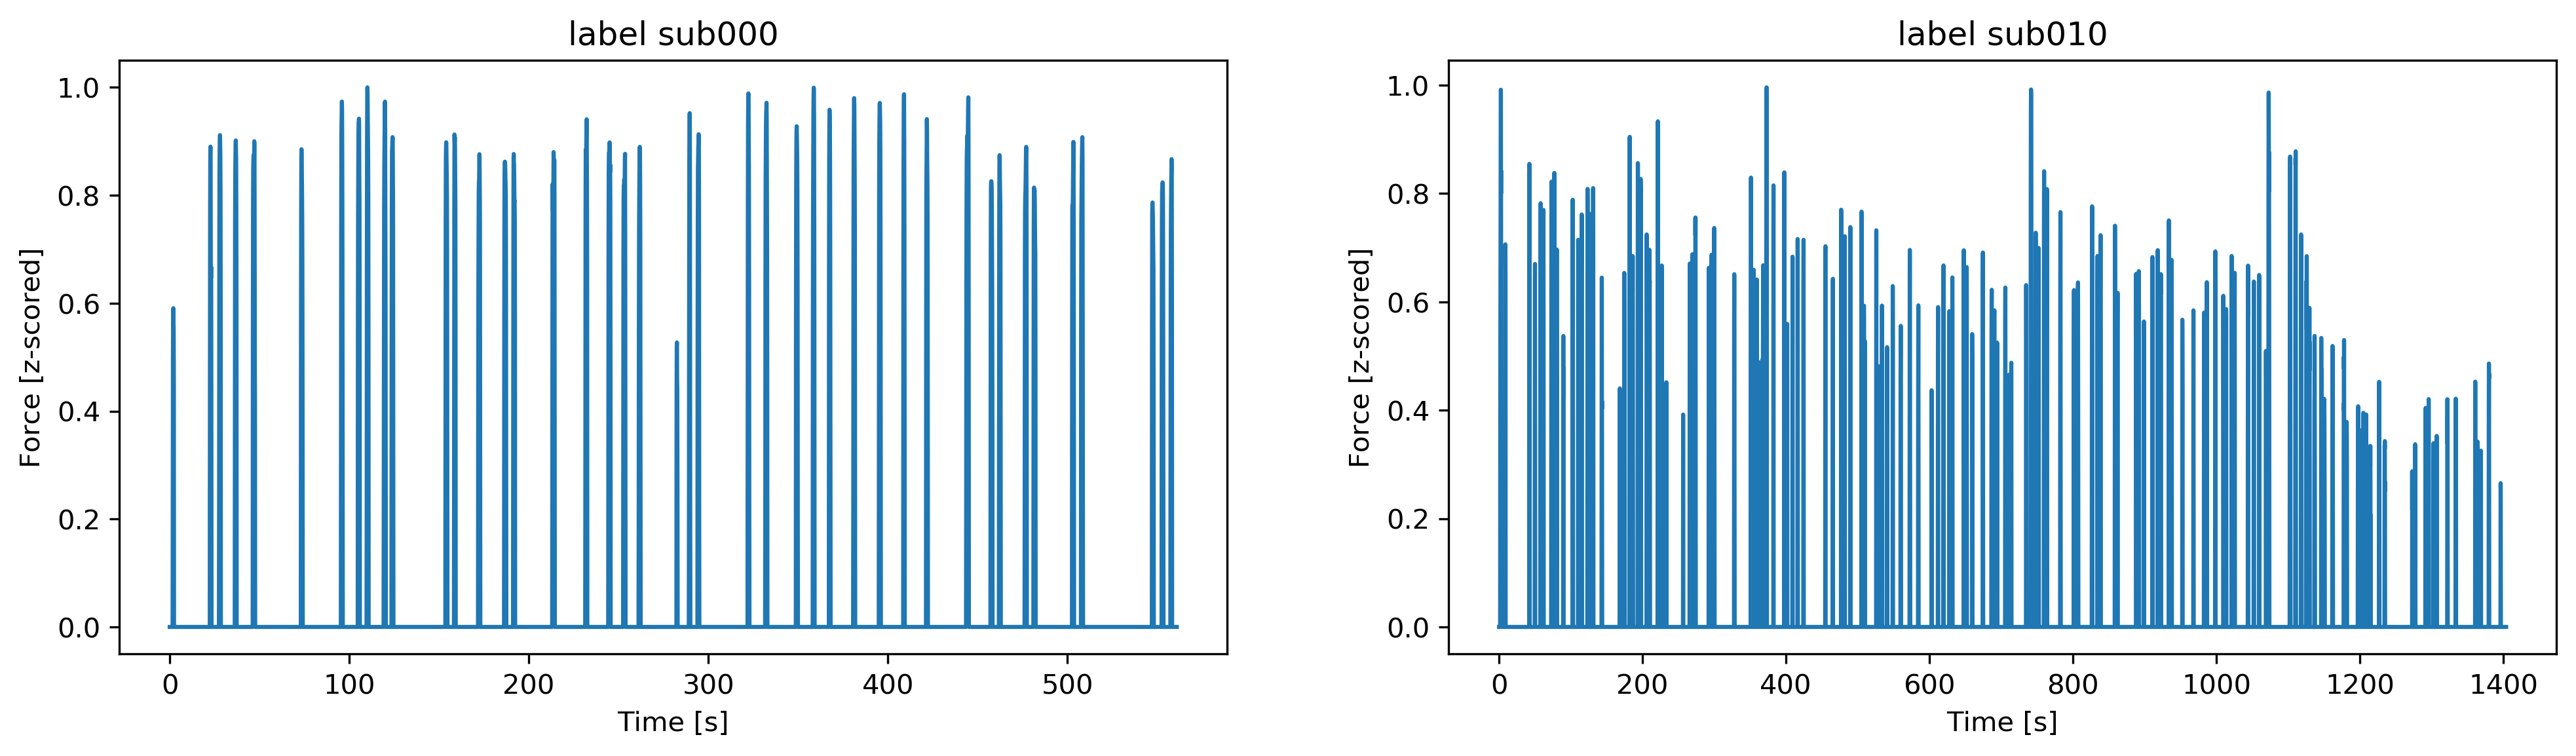

In [64]:
plt.figure(figsize=(16,4), dpi=300)
plt.subplot(121)
plt.title("label sub000")
plt.xlabel("Time [s]")
plt.ylabel("Force [z-scored]")
plt.plot(np.arange(0, dict_["000"]["true"].shape[0], 1)*0.1,dict_["000"]["true"]) 
plt.subplot(122)
plt.plot(np.arange(0, dict_["010"]["true"].shape[0], 1)*0.1,dict_["010"]["true"]) 
plt.title("label sub010")
plt.xlabel("Time [s]")
plt.ylabel("Force [z-scored]")

### spearman's rho p values

In [71]:
sprho_arr_delta = np.zeros([epoch_lim*2, 2]) # 0:rho, 1:p
sprho_arr_pred = np.zeros([epoch_lim*2, 2])
for i in range(epoch_lim*2):
    print(i)
    sprho_arr_delta[i,0] = stats.spearmanr(mean_arr_delta[i,:], updrs)[0]
    sprho_arr_pred[i,0] = stats.spearmanr(mean_arr_pred[i,:], updrs)[0]
    
    sprho_arr_delta[i,1] = icn_permutation_test.permutationTestSpearmansRho(mean_arr_delta[i,:], 
                                                       np.array(updrs), False, r"$R^2$", 10000)[1]
    sprho_arr_pred[i,1] = icn_permutation_test.permutationTestSpearmansRho(mean_arr_pred[i,:], 
                                                       np.array(updrs), False, r"$R^2$", 10000)[1]

In [83]:
icn_permutation_test.permutationTestSpearmansRho(mean_arr_delta[i,:], 
                                                       np.array(updrs), False, r"$R^2$", 10000)

(0.004555820475782052, 0.4916)

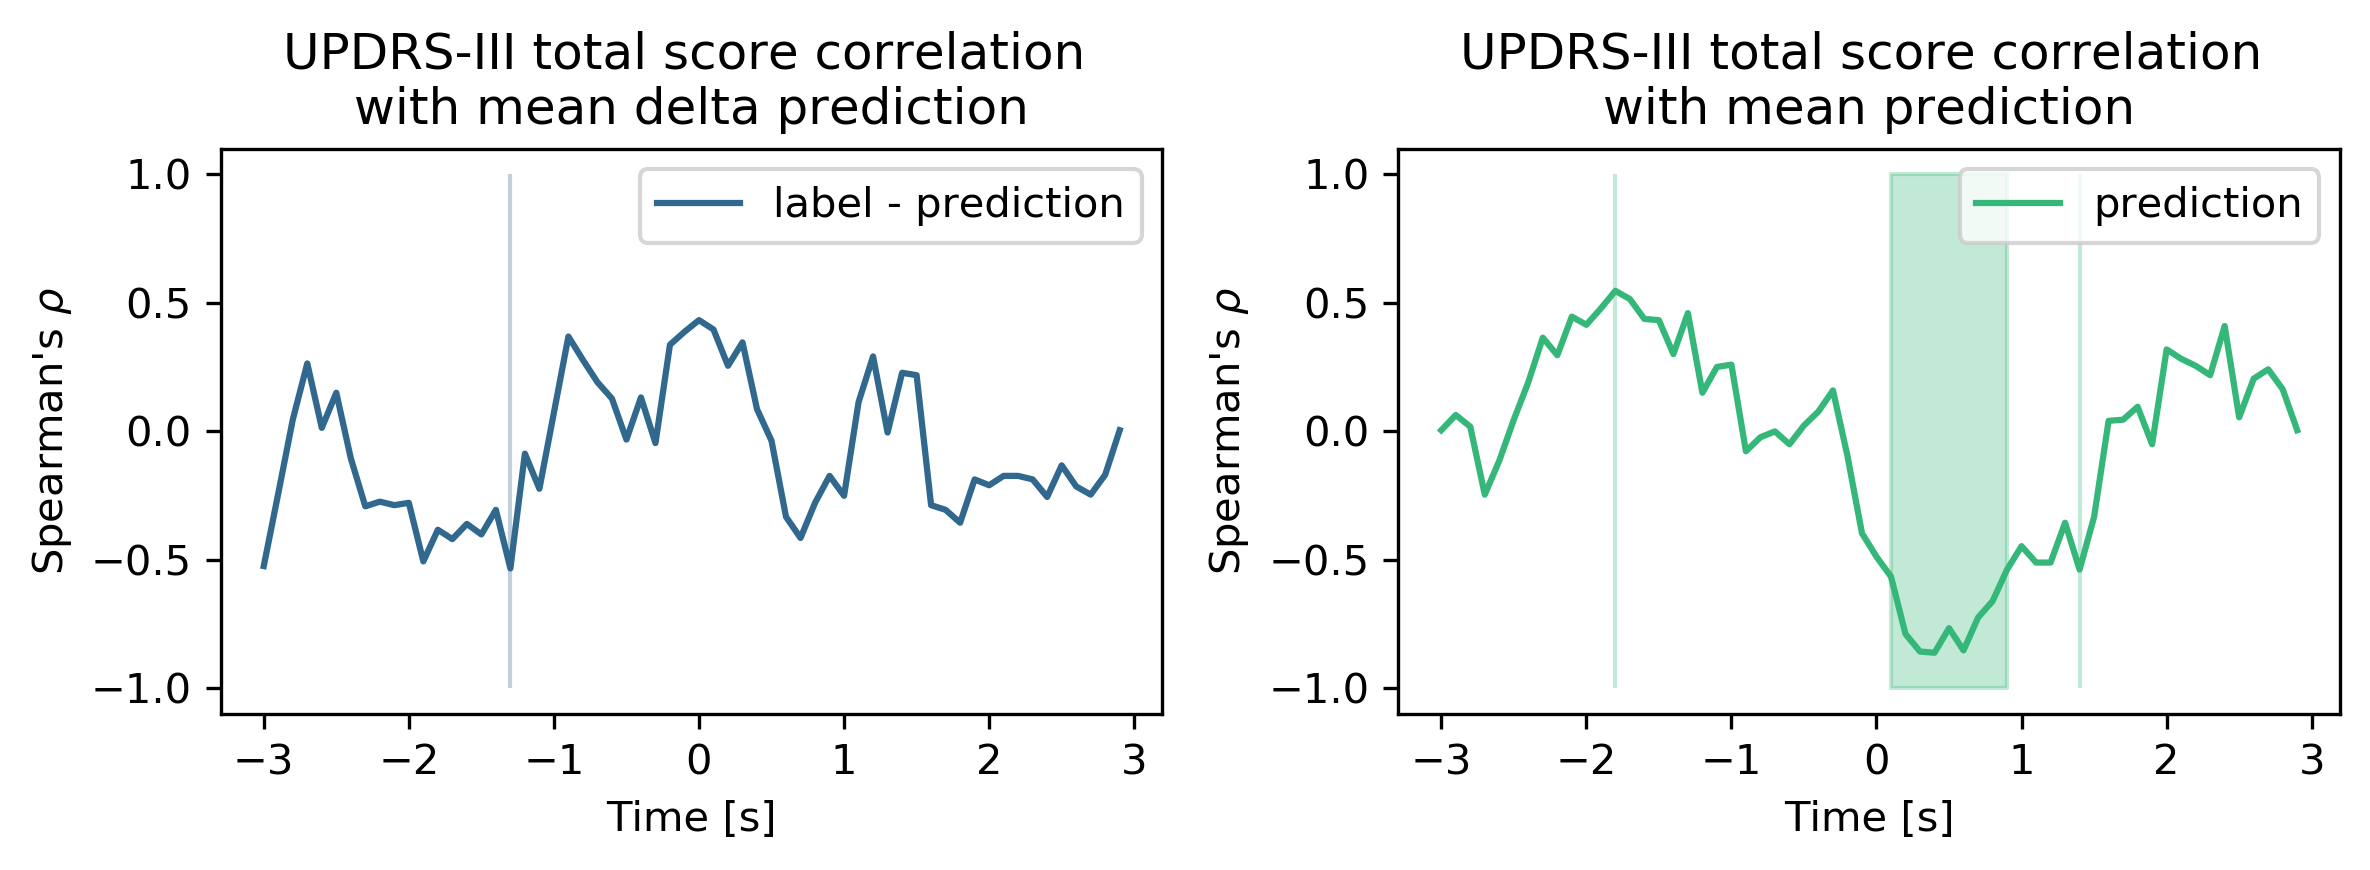

In [88]:
plt.figure(figsize=(8,3), dpi=300)
plt.subplot(121)
x_ = np.arange(-epoch_lim, epoch_lim, 1)*0.1
plt.plot(x_, sprho_arr_delta[:,0], label="label - prediction", color=(49/255,104/255,142/255))
#plt.plot(x_, sprho_arr_pred, label = "prediction",color=(53/255,183/255,121/255))
plt.fill_between(x_, -1,1, where=sprho_arr_delta[:,1] <0.05, alpha=0.3, color=(49/255,104/255,142/255))
plt.ylabel("Spearman's "+r"$\rho$")
plt.xlabel("Time [s]")
plt.legend()
plt.title("UPDRS-III total score correlation \nwith mean delta prediction")

plt.subplot(122)
x_ = np.arange(-epoch_lim, epoch_lim, 1)*0.1
#plt.plot(x_, sprho_arr_delta, label="label - prediction", color=(49/255,104/255,142/255))
plt.plot(x_, sprho_arr_pred[:,0], label = "prediction",color=(53/255,183/255,121/255))
plt.fill_between(x_, -1,1, where=sprho_arr_pred[:,1] <0.05, alpha=0.3, color=(53/255,183/255,121/255))
plt.ylabel("Spearman's "+r"$\rho$")
plt.xlabel("Time [s]")
plt.legend()
plt.title("UPDRS-III total score correlation \nwith mean prediction")
plt.tight_layout()

### fit von Amplitude zu UPDRS um R^2 predicten

In [ ]:
updrs
mittlere amplitude von höchsten punkt ermitteln

In [323]:
df_UPDRS_as_feature = pd.DataFrame()
epoch_lim = 30
start = True
for sub_idx, sub in enumerate(['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']):
    y_epoch_true, y_epoch_pr = get_epochs(dict_[sub]["true"], dict_[sub]["pred"], \
                                          threshold=0.5, epoch_lim=epoch_lim)
    df_UPDRS_as_feature = df_UPDRS_as_feature.append({
        "updrs" : list(df_UPDRS[(df_UPDRS["sub"] == int(sub))]["UPDRS_total"])[0], 
        "amp_pr" : np.mean(y_epoch_pr, axis=0).max(), 
        "r2" : dict_[sub]["r2"], 
        "sub" : sub, 
        "amp_te" : np.mean(y_epoch_true, axis=0)[np.mean(y_epoch_pr, axis=0).argmax()]
    }, ignore_index=True)


In [115]:
icn_permutation_test.permutationTestSpearmansRho(df_UPDRS_as_feature["amp"], 
                                                       df_UPDRS_as_feature["updrs"], False, r"$R^2$", 10000)

(-0.8610500699228079, 0.0004)

In [117]:
stats.spearmanr(df_UPDRS_as_feature["amp"], df_UPDRS_as_feature["updrs"])

SpearmanrResult(correlation=-0.8610500699228079, pvalue=0.0006630680655063411)

Text(0.5, 1.0, 'prediction amplitude UPDRS-III total correlation\n$\\rho$=-0.86 p=0.0006')

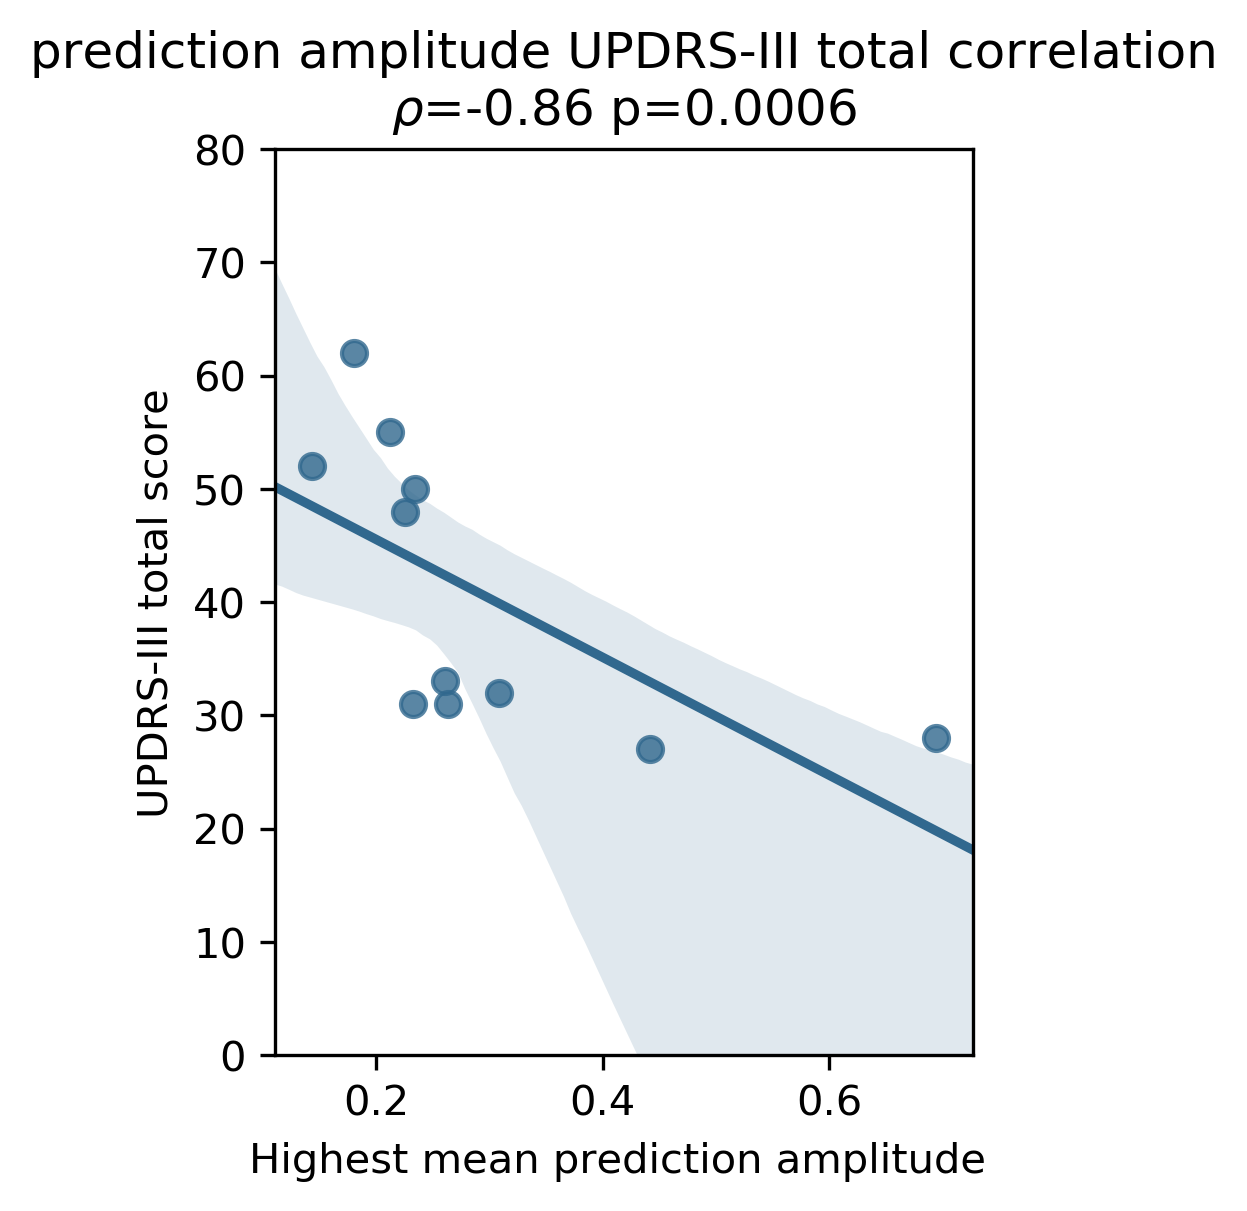

In [125]:
plt.figure(figsize=(3,4), dpi=300)
sb.regplot(x="amp", y="updrs", data=df_UPDRS_as_feature, color=(49/255,104/255,142/255))
plt.ylim(0, 80)
plt.ylabel("UPDRS-III total score")
plt.xlabel("Highest mean prediction amplitude ")
plt.title("prediction amplitude UPDRS-III total correlation\n"+r"$\rho$"+"=-0.86 p=0.0006")

### now the intresting bit

### linear regression

In [126]:
df_UPDRS_as_feature

,amp,r2,sub,updrs
0,0.694069,0.644513,000,28.0
1,0.442021,0.401527,001,27.0
2,0.261067,0.217728,004,33.0
3,0.232283,0.128635,005,31.0
4,0.308708,0.231558,006,32.0
5,0.143362,0.011627,007,52.0
6,0.212465,0.187314,008,55.0
7,0.234741,0.000000,009,50.0
8,0.180864,0.092526,010,62.0
9,0.225715,0.052764,013,48.0


In [128]:
df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]

,amp,r2,sub,updrs
10,0.263281,0.025927,014,31.0


In [324]:
df_predict_highest_amp = pd.DataFrame()
for sub in df_UPDRS_as_feature["sub"].unique():
    d_test = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]
    d_train = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] != sub]
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(d_train[["amp_pr", "updrs"]], d_train["amp_te"])
        
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(d_train[["amp_pr", "updrs"]], d_train["amp_te"])
    
    df_predict_highest_amp = df_predict_highest_amp.append(
        {
            "method" : "XGBOOST", 
            "diff" : [d_test["amp_te"] - xgb_reg.predict(d_test[["amp_pr", "updrs"]])][0].iloc[0], 
            "sub" : sub
        }, ignore_index=True)
    df_predict_highest_amp = df_predict_highest_amp.append(
        {
            "method" : "linReg", 
            "diff" : [d_test["amp_te"] - lin_reg.predict(d_test[["amp_pr", "updrs"]])][0].iloc[0],
            "sub" : sub
        }, ignore_index=True)
    df_predict_highest_amp = df_predict_highest_amp.append(
        {
            "method" : "baseline", 
            "diff" : [d_test["amp_te"] - d_test["amp_pr"]][0].iloc[0],
            "sub" : sub
        }, ignore_index=True)

In [325]:
df_predict_highest_amp

,diff,method,sub
0,0.040292,XGBOOST,000
1,0.098457,linReg,000
2,0.146078,baseline,000
3,0.073893,XGBOOST,001
4,0.027092,linReg,001
5,0.292422,baseline,001
6,-0.044040,XGBOOST,004
7,-0.057356,linReg,004
8,0.300190,baseline,004
9,-0.032521,XGBOOST,005


In [200]:
XGB_diff = str(np.round(np.mean(df_predict_highest_amp[df_predict_highest_amp["method"] == "XGBOOST"]["diff"]), 3)) + \
    r"$\pm$"+ str(np.round(np.std(df_predict_highest_amp[df_predict_highest_amp["method"] == "XGBOOST"]["diff"]), 3))
LM_diff = str(np.round(np.mean(df_predict_highest_amp[df_predict_highest_amp["method"] == "linReg"]["diff"]), 3)) + \
    r"$\pm$"+ str(np.round(np.std(df_predict_highest_amp[df_predict_highest_amp["method"] == "linReg"]["diff"]), 3))
baseline_diff = str(np.round(np.mean(df_predict_highest_amp[df_predict_highest_amp["method"] == "baseline"]["diff"]), 3)) + \
    r"$\pm$"+ str(np.round(np.std(df_predict_highest_amp[df_predict_highest_amp["method"] == "baseline"]["diff"]), 3))

Text(0.5, 0, 'Method')

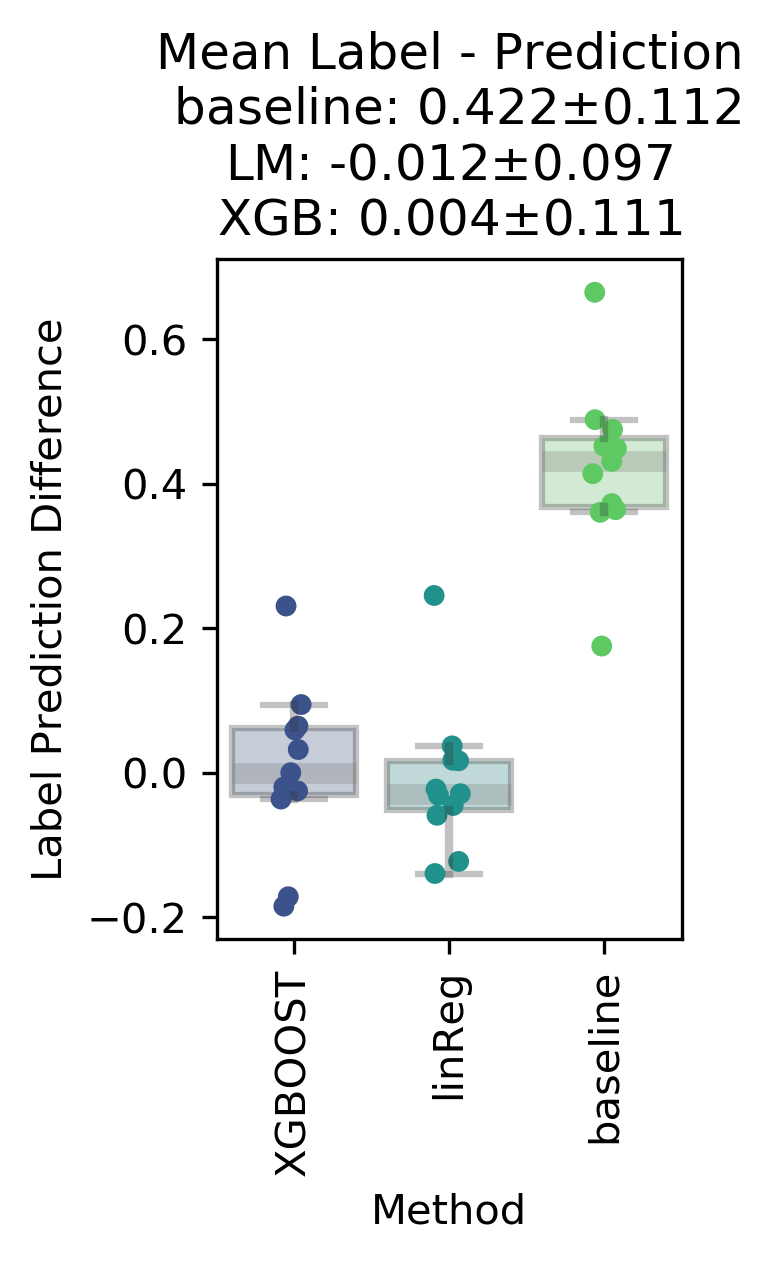

In [215]:
plt.figure(figsize=(2,3), dpi=300)
alpha_box = 0.3
sb.boxplot(x="method", y="diff", order=["XGBOOST", "linReg", "baseline"], data=df_predict_highest_amp,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False, dodge=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="method", y="diff", order=["XGBOOST", "linReg", "baseline"], data=df_predict_highest_amp,
             palette="viridis", dodge=True, s=5)

#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Mean Label - Prediction\n baseline: "+str(baseline_diff) + "\nLM: "+str(LM_diff)+ "\nXGB: "+str(XGB_diff))
plt.xticks(rotation=90)
plt.ylabel("Label Prediction Difference")
plt.xlabel("Method")

### get updated new preictions

In [400]:
# after that now: 
# based on the Linear cross validated LM apply the model to the prediction epochs
# (linear Model!)
# get the MEAN predictions now for every subject 

In [401]:
from sklearn.utils import shuffle
def get_train_UPDRS(sub_test):
    start= True
    for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        if sub == sub_test:
            X__test = np.concatenate((np.expand_dims(np.repeat(df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]["updrs"].iloc[0], 
                  dict_[sub]["pred"].shape[0]), axis=0),
                  np.expand_dims(dict_[sub]["pred"], axis=0)), axis=0)
            y__test = dict_[sub]["true"]
            continue
        if start == True:
            start = False
            X__train = np.concatenate((np.expand_dims(np.repeat(df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]["updrs"].iloc[0], 
                  dict_[sub]["pred"].shape[0]), axis=0),
                  np.expand_dims(dict_[sub]["pred"], axis=0)), axis=0)
            y__train = dict_[sub]["true"]
        else:
            X__train = np.concatenate((X__train, np.concatenate((np.expand_dims(np.repeat(df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]["updrs"].iloc[0], 
                  dict_[sub]["pred"].shape[0]), axis=0),
                  np.expand_dims(dict_[sub]["pred"], axis=0)), axis=0)), axis=1)
            y__train = np.concatenate((y__train, dict_[sub]["true"]), axis=0)
    #X__train, y__train = shuffle(X__train.T, y__train)
    #X__test, y__test = shuffle(X__test.T, y__test)
    return X__train.T, y__train, X__test.T, y__test

In [403]:
df_UPDRS_as_feature_PREDICTIONS = pd.DataFrame()
epoch_lim = 30
for sub_idx, sub in enumerate(['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']):
    d_test = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]
    d_train = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] != sub]
    xgb_reg = xgb.XGBRegressor()
    X__train, y__train, X__test, y__test = get_train_UPDRS(sub)
    xgb_reg.fit(X__train, y__train)
    y_pred_using_UPDRS = xgb_reg.predict(X__test)
    
    r2_now = metrics.r2_score(dict_[sub]["true"], y_pred_using_UPDRS)
    
    y_epoch_true, y_epoch_pr = get_epochs(dict_[sub]["true"], dict_[sub]["pred"], \
                                          threshold=0.5, epoch_lim=epoch_lim)
    
    _, y_epoch_pr_WITH_UPDRS = get_epochs(dict_[sub]["true"], y_pred_using_UPDRS, \
                                          threshold=0.5, epoch_lim=epoch_lim)
    
    df_UPDRS_as_feature_PREDICTIONS = df_UPDRS_as_feature_PREDICTIONS.append({
        "updrs" : list(df_UPDRS[(df_UPDRS["sub"] == int(sub))]["UPDRS_total"])[0], 
        "r2" : dict_[sub]["r2"], 
        "r2_now" : r2_now,
        "sub" : sub, 
        "y_epoch_true" : y_epoch_true, 
        "y_epoch_pr" : y_epoch_pr, 
        "y_epoch_pr_WITH_UPDRS" : y_epoch_pr_WITH_UPDRS
    }, ignore_index=True)


Text(0.5, 1.0, 'performance comparison Cross validated')

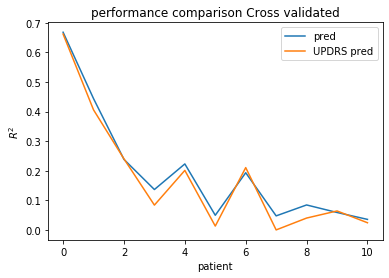

In [404]:
plt.plot(df_UPDRS_as_feature_PREDICTIONS["r2"], label="pred")
plt.plot(df_UPDRS_as_feature_PREDICTIONS["r2_now"], label="UPDRS pred")
plt.legend()
plt.ylabel(r"$R^2$")
plt.xlabel("patient")
plt.title("performance comparison Cross validated")

### NON CV

In [407]:
df_UPDRS_as_feature_PREDICTIONS_NON_CV = pd.DataFrame()
epoch_lim = 30
# KEINE TIME STAMPS hies
for sub_idx, sub in enumerate(['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']):
    d_test = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] == sub]
    d_train = df_UPDRS_as_feature[df_UPDRS_as_feature["sub"] != sub]
    xgb_reg = xgb.XGBRegressor()
    X__train, y__train, X__test, y__test = get_train_UPDRS(sub)
    
    label_= []
    pred_ = []
    cv = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in cv.split(X__test):
        #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=label[time_stamps:]), 
        #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
        Xtr, Xte=X__test[train_index,:], X__test[test_index,:]
        ytr, yte=y__test[train_index], y__test[test_index]
        model = xgb.XGBRegressor()
        model.fit(Xtr, ytr)
        model.predict(Xte)
        pred_.append(model.predict(Xte))
        label_.append(yte)
    
    y_pred_using_UPDRS = np.concatenate(pred_, axis=0)
    r2_now = metrics.r2_score(dict_[sub]["true"], y_pred_using_UPDRS)
    y_epoch_true, y_epoch_pr = get_epochs(dict_[sub]["true"], dict_[sub]["pred"],\
                                          threshold=0.5, epoch_lim=epoch_lim)
    
    _, y_epoch_pr_WITH_UPDRS = get_epochs(dict_[sub]["true"], y_pred_using_UPDRS, \
                                          threshold=0.5, epoch_lim=epoch_lim)
    
    df_UPDRS_as_feature_PREDICTIONS_NON_CV = df_UPDRS_as_feature_PREDICTIONS_NON_CV.append({
        "updrs" : list(df_UPDRS[(df_UPDRS["sub"] == int(sub))]["UPDRS_total"])[0], 
        "r2" : dict_[sub]["r2"], 
        "r2_now" : r2_now,
        "sub" : sub, 
        "y_epoch_true" : y_epoch_true, 
        "y_epoch_pr" : y_epoch_pr, 
        "y_epoch_pr_WITH_UPDRS" : y_epoch_pr_WITH_UPDRS
    }, ignore_index=True)


In [409]:
np.mean(df_UPDRS_as_feature_PREDICTIONS_NON_CV["r2"])

0.19831713858673294

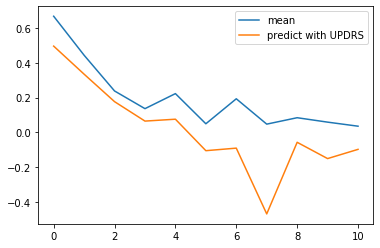

In [412]:
plt.plot(df_UPDRS_as_feature_PREDICTIONS_NON_CV["r2"], label="mean")
plt.plot(df_UPDRS_as_feature_PREDICTIONS_NON_CV["r2_now"], label="predict with UPDRS")
plt.legend()

In [347]:
df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == "000"]

,r2,r2_now,sub,updrs,y_epoch_pr,y_epoch_pr_WITH_UPDRS,y_epoch_true
0,0.797281,-0.879537,000,28.0,"[[0.515691876411438, 0.00014713406562805176, -...","[[0.0008571445941925049, 0.0008571445941925049...","[[0.5521536155004447, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [357]:
df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == 
                "000"]["y_epoch_pr"][0].shape

(182, 60)

In [388]:
df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == 
                "001"]["y_epoch_true"].iloc[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.90558215, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.87740973]])

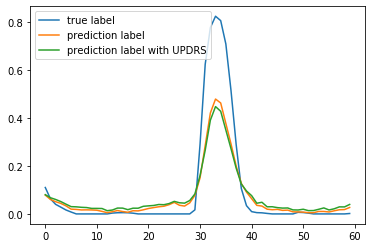

In [405]:
plt.plot(df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == 
                "001"]["y_epoch_true"].iloc[0].mean(axis=0), label="true label")
plt.plot(df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == 
                "001"]["y_epoch_pr"].iloc[0].mean(axis=0), label="prediction label")
plt.plot(df_UPDRS_as_feature_PREDICTIONS[df_UPDRS_as_feature_PREDICTIONS["sub"] == 
                "001"]["y_epoch_pr_WITH_UPDRS"].iloc[0].mean(axis=0), label="prediction label with UPDRS")
plt.legend()

In [343]:
df_UPDRS_as_feature_PREDICTIONS["r2"].mean()

0.4153698892358978

In [345]:
-df_UPDRS_as_feature_PREDICTIONS["r2_now"].mean()

0.46682434915504023

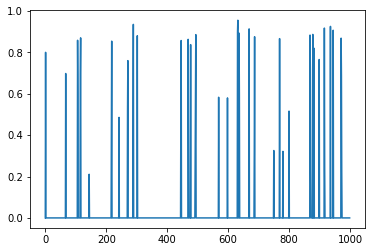

In [396]:
plt.plot(dict_["001"]["true"][1000:2000])

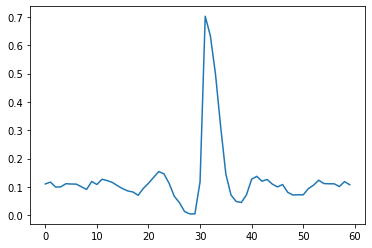

In [377]:
plt.plot(y_epoch_true.mean(axis=0))